In [1]:
import os
import sep
import numpy as np
import numba as nb
from glob import glob
from astropy.io import fits
from astropy.time import Time
from copy import deepcopy
from pathlib import Path
import datetime
import matplotlib.pyplot as plt
import os
import gc
import time as timer
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import numpy as np
import concurrent.futures
import matplotlib.pyplot as plt
import numpy as np
import numba as nb
from matplotlib.colors import LogNorm

In [2]:
# Function for reading specified number of bytes
def readxbytes(fid, numbytes):
    for i in range(1):
        data = fid.read(numbytes)
        if not data:
            break
    return data

# Function to read 12-bit data with Numba to speed things up
@nb.njit(nb.uint16[::1](nb.uint8[::1]),fastmath=True,parallel=True)
def nb_read_data(data_chunk):
    """data_chunk is a contigous 1D array of uint8 data)
    eg.data_chunk = np.frombuffer(data_chunk, dtype=np.uint8)"""
    #ensure that the data_chunk has the right length

    assert np.mod(data_chunk.shape[0],3)==0

    out=np.empty(data_chunk.shape[0]//3*2,dtype=np.uint16)
    image1 = np.empty((2048,2048),dtype=np.uint16)
    image2 = np.empty((2048,2048),dtype=np.uint16)

    for i in nb.prange(data_chunk.shape[0]//3):
        fst_uint8=np.uint16(data_chunk[i*3])
        mid_uint8=np.uint16(data_chunk[i*3+1])
        lst_uint8=np.uint16(data_chunk[i*3+2])

        out[i*2] =   (fst_uint8 << 4) + (mid_uint8 >> 4)
        out[i*2+1] = ((mid_uint8 % 16) << 8) + lst_uint8

    return out

def getSizeRCD(filenames):
    """ MJM - Get the size of the images and number of frames """
    filename_first = filenames[0]
    frames = len(filenames)

    width = 2048
    height = 2048

    # You could also get this from the RCD header by uncommenting the following code
    # with open(filename_first, 'rb') as fid:
    #     fid.seek(81,0)
    #     hpixels = readxbytes(fid, 2) # Number of horizontal pixels
    #     fid.seek(83,0)
    #     vpixels = readxbytes(fid, 2) # Number of vertical pixels

    #     fid.seek(100,0)
    #     binning = readxbytes(fid, 1)

    #     bins = int(binascii.hexlify(binning),16)
    #     hpix = int(binascii.hexlify(hpixels),16)
    #     vpix = int(binascii.hexlify(vpixels),16)
    #     width = int(hpix / bins)
    #     height = int(vpix / bins)

    return width, height, frames

# Function to split high and low gain images
def split_images(data,pix_h,pix_v,gain):
    interimg = np.reshape(data, [2*pix_v,pix_h])

    if gain == 'low':
        image = interimg[::2]
    else:
        image = interimg[1::2]

    return image
 
# Function to read RCD file data
def readRCD(filename):

    hdict = {}

    with open(filename, 'rb') as fid:

        # Go to start of file
        fid.seek(0,0)

        # Serial number of camera
        fid.seek(63,0)
        hdict['serialnum'] = readxbytes(fid, 9)

        # Timestamp
        fid.seek(152,0)
        hdict['timestamp'] = readxbytes(fid, 29).decode('utf-8')

        # Load data portion of file
        fid.seek(384,0)

        table = np.fromfile(fid, dtype=np.uint8, count=12582912)

    return table, hdict

# Image Viewer

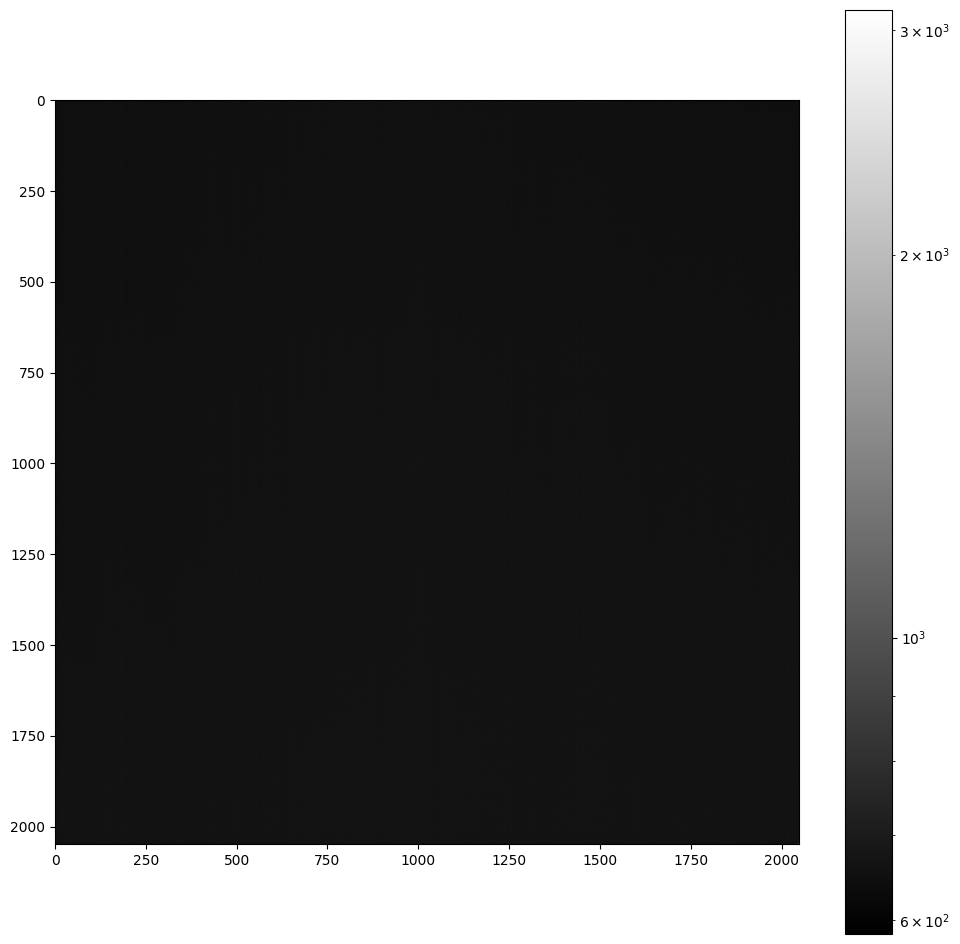

In [6]:
import os
import imageio
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from astropy.io import fits

image_file = "/home/agirmen/research_data/research_data/rcd_images/Alt41.8_25ms-_0000001.rcd"

# read and plot the rcd high gain image in a big figure
data, header = readRCD(image_file)
data = nb_read_data(data)
high_gain_image = split_images(data,2048,2048,'high')
plt.figure(figsize=(12,12))
plt.imshow(high_gain_image, cmap='gray', norm=LogNorm())
plt.colorbar()
plt.show()

# Video Maker

In [7]:
import os
import imageio
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from astropy.io import fits

In [16]:
import os
import imageio
import numpy as np
from astropy.io import fits

data_dir = "/home/agirmen/research_data/research_data/rcd_images/20240729_03.11.42.783_relevant_images/"

# Get the filepaths of all the files in the directory
filepaths = []
for root, dirs, files in os.walk(data_dir):
    files.sort()
    for file in files:
        if file.endswith(".rcd"):
            filepaths.append(os.path.join(root, file))
print(filepaths)

hnumpix = 2048
vnumpix = 2048

# Initialize the video writer
output_video_path = '20240729_03.11.42.red.mp4'
writer = imageio.get_writer(output_video_path, fps=10)

# Initialize the running average buffer
running_avg = None
alpha = 1  # Smoothing factor

# Loop through each file
for i, filepath in enumerate(filepaths):
    print(f"Processing frame {i+1}/{len(filepaths)}")
    # Read the file
    data, header = readRCD(filepath)
    images_data = nb_read_data(data)
    
    # Process the image (split into low and high gain)
    low_gain = split_images(images_data, hnumpix, vnumpix, 'low')
    high_gain = split_images(images_data, hnumpix, vnumpix, 'high')
    
    # Normalize the high_gain image
    high_gain_normalized = (high_gain - np.min(high_gain)) / (np.max(high_gain) - np.min(high_gain)) * 255
    high_gain_normalized = high_gain_normalized.astype(np.uint8)
    
    # Update the running average
    if running_avg is None:
        running_avg = high_gain_normalized.astype(np.float32)
    else:
        running_avg = alpha * high_gain_normalized + (1 - alpha) * running_avg
    
    # Convert the running average to uint8
    smoothed_frame = running_avg.astype(np.uint8)
    
    # Write the smoothed frame to the video
    writer.append_data(smoothed_frame)

# Close the video writer
writer.close()

print(f"Video saved to {output_video_path}")

['/home/agirmen/research_data/research_data/rcd_images/20240729_03.11.42.783_relevant_images/Alt14.5_100ms-_0000500.rcd', '/home/agirmen/research_data/research_data/rcd_images/20240729_03.11.42.783_relevant_images/Alt14.5_100ms-_0000501.rcd', '/home/agirmen/research_data/research_data/rcd_images/20240729_03.11.42.783_relevant_images/Alt14.5_100ms-_0000502.rcd', '/home/agirmen/research_data/research_data/rcd_images/20240729_03.11.42.783_relevant_images/Alt14.5_100ms-_0000503.rcd', '/home/agirmen/research_data/research_data/rcd_images/20240729_03.11.42.783_relevant_images/Alt14.5_100ms-_0000504.rcd', '/home/agirmen/research_data/research_data/rcd_images/20240729_03.11.42.783_relevant_images/Alt14.5_100ms-_0000505.rcd', '/home/agirmen/research_data/research_data/rcd_images/20240729_03.11.42.783_relevant_images/Alt14.5_100ms-_0000506.rcd', '/home/agirmen/research_data/research_data/rcd_images/20240729_03.11.42.783_relevant_images/Alt14.5_100ms-_0000507.rcd', '/home/agirmen/research_data/re